### Import Data and Library

In [1]:
# Import the libraries
import os
import sys
from IPython.display import HTML, display

import numpy as np
import pandas as pd
import tensorflow as tf
from math import ceil
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import seaborn as sns

import collections
import random
import time
import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, LSTM, Bidirectional

/Users/estelle/opt/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/estelle/opt/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/estelle/opt/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/estelle/opt/anaconda3/envs/tf/lib

In [2]:
summary_path = "/Users/estelle/Desktop/NLP_app/MutualFundSummary"
summary_lables_path = "/Users/estelle/Desktop/NLP_app/MutualFundLabels.csv"
glove_word2vec = '/Users/estelle/Desktop/NLP_app/glove.6B.50d.txt'
our_word2vec = '/Users/estelle/Desktop/NLP_app/word2vec_perso.txt'

In [3]:
#Util
# Progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Save a word2vec dictionary.
def save_word2vec(filename):
    with open(os.path.join('/Users/haoxing/Documents/Work/Teaching/Machine learning for Finance/Codes/NLP/NLP_app', filename),'a' , encoding='utf-8') as f :
        for k, v in word2vec.items():
            line = k+' '+str(list(v)).strip('[]').replace(',','')+'\n'
            f.write(line)

# Load a word2vec dictionary.
def load_word2vec(filename):
    word2vec = {}
    with open(os.path.join('/Users/haoxing/Documents/Work/Teaching/Machine learning for Finance/Codes/NLP/NLP_app', filename), encoding='utf8') as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec

# read the repo in PATH and append the texts in a list
def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="utf8") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        texts.append(summary)
        fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

In [4]:
#Get the summaries
fund_names, summaries = get_data(summary_path)

In [5]:
stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'])

In [6]:
# clean and tokenize the text -> we don't want to lemmatize
def tokenizer(txt):
    txt = txt.replace('\n', ' ').replace('\t', ' ').lower()
    word_tokens = word_tokenize(txt)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = [w for w in filtered_sentence if re.sub("[^A-Za-z ]+",'',w) != ''] 
    return filtered_sentence

In [7]:
text_words = np.concatenate([tokenizer(summary) for summary in summaries])
print(text_words[:20])

['investment' 'objective' 'thrivent' 'partner' 'healthcare' 'portfolio'
 'portfolio' 'seeks' 'long-term' 'capital' 'growth' 'fees' 'expenses'
 'table' 'describes' 'fees' 'expenses' 'may' 'pay' 'buy']


### Process skip-gram model input

In [8]:
# Training Parameters
batch_size = 128 # The model will be trained batch per batch and one batch contains 128 rows
num_epochs = 2 # The model will go through all the data twice

In [9]:
# Word2Vec Parameters
embedding_size = 50 # Dimension of the embedding vector
max_vocabulary_size = 5000 # Total number of different words in the vocabulary
min_occurrence = 10 # Remove all words that does not appears at least n times
skip_window = 3 # How many words to consider left and right
num_skips = 4 # How many times to reuse an input to generate a label

In [10]:
import collections
# Build the dictionary and replace rare words with UNK token
count = [('UNK', -1)]
# Retrieve the most common words
count.extend(collections.Counter(text_words).most_common(max_vocabulary_size - 1))
# Remove samples with less than 'min_occurrence' occurrences
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        # The collection is ordered, so stop when 'min_occurrence' is reached
        break

In [12]:
word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i
id2word = dict(zip(word2id.values(), word2id.keys()))
vocab_size = len(id2word)

In [13]:
# create data
data = list()
unk_count = 0
for word in text_words:
    # Retrieve a word id, or assign it index 0 ('UNK') if not in dictionary
    index = word2id.get(word, 0)
    if index == 0:
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count)

In [14]:
print(data[:20])

[3, 123, 3353, 498, 1843, 7, 7, 231, 281, 73, 91, 12, 9, 49, 338, 12, 9, 2, 66, 184]


In [15]:
# build OneHot vector from index
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

In [16]:
# Generate training batch for the skip-gram model
def batch_generator(batch_size, num_skips, skip_window, vocab_size):
    data_index = 0
    while True :
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window
        # batch is filled with 128 inputs
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        # labels is filled with 128 outputs 
        labels = np.ndarray(shape=(batch_size), dtype=np.int32)
        span = 2 * skip_window + 1
        # buffer keep track of the visited indexes visited
        buffer = collections.deque(maxlen=span)
        if data_index + span > len(data):
            data_index = 0
            # We stop the loop when we went through all the corpus
            break
        buffer.extend(data[data_index:data_index + span])
        data_index += span
        for i in range(batch_size // num_skips):  
            # Take the context current word
            context_words = [w for w in range(span) if w != skip_window]
            # Randomly select num_skips words in the context
            words_to_use = random.sample(context_words, num_skips)
            for j, context_word in enumerate(words_to_use):
                # Creates one raw data
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j] = buffer[context_word]
            if data_index == len(data):
                buffer.extend(data[0:span])
                data_index = span
            else:
                buffer.append(data[data_index])
                data_index += 1
        # Backtrack a little bit to avoid skipping words in the end of a batch
        data_index = (data_index + len(data) - span) % len(data)

        # translate word index to on-hot representation
        batch_one_hot = np.array([to_one_hot(b, vocab_size) for b in batch])
        labels_one_hot = np.array([to_one_hot(l, vocab_size) for l in labels])

        # output one batch
        yield batch_one_hot, labels_one_hot

### Train the skip-gram model

In [17]:
# Create en compile the Autoencoder
def creat_word2vec_model():
    input_word = Input(shape=(vocab_size,))

    encoded = Dense(embedding_size, activation='linear')(input_word)
    decoded = Dense(vocab_size, activation='softmax')(encoded)

    # The autoencoder is the whole model with hidden layer contected to the output layer.
    autoencoder = Model(input_word, decoded)
    # The encoder is just the input layer connected to the hidden layer. One the Autoencoder will be trained we will use
    # the encoder to create our word vectors 
    encoder = Model(input_word, encoded)
    
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return encoder, autoencoder

In [18]:
# We create the model
encoder, autoencoder = creat_word2vec_model()

In [19]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3454)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                172750    
_________________________________________________________________
dense_1 (Dense)              (None, 3454)              176154    
Total params: 348,904
Trainable params: 348,904
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Finally we can train the model by feeding it with our batch generator !
autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)

Epoch 1/2
7481/7481 [==============================] - 274s 37ms/step - loss: 0.0022
Epoch 2/2
7481/7481 [==============================] - 273s 36ms/step - loss: 0.0020


In [21]:
# Create the Vectorizer function (prediciton of the encoder)
def vecotrize(word):
    word_one_hot = to_one_hot(word2id[word], vocab_size)
    return encoder.predict(np.array([word_one_hot]))[0]

In [22]:
# Create the word2vec dictionary
word2vec = {w : vecotrize(w) for w in word2id.keys()}

# This dictionary gives for all words it's vectorial representation.

In [23]:
save_word2vec(our_word2vec)

### Data Visualization

#### find the closer words

In [24]:
# for a given word, output the n closer words in the word2vec maping.
def get_n_closer(w, n, word2vec):
    vect = word2vec[w]
    distances_dict = {k: cosine(v, vect) for k, v in word2vec.items()}
    
    closer_words = []
    for _ in range(n):
        min_key = min(distances_dict.keys(), key=lambda k: distances_dict[k])
        closer_words.append(min_key)
        del distances_dict[min_key]
    return closer_words

In [25]:
words_neighbors_1 = get_n_closer('preservation', 10, word2vec)
print('words close to balanced : ' +str(', '.join(words_neighbors_1)))
words_neighbors_2 = get_n_closer('bonds', 10, word2vec)
print('words close to fixed income : ' +str(', '.join(words_neighbors_2)))
words_neighbors_3 = get_n_closer('stocks', 10, word2vec)
print('words close to equity : ' +str(', '.join(words_neighbors_3)))
words_neighbors_4 = get_n_closer('leverage', 10, word2vec)
print('words close to long short funds : ' +str(', '.join(words_neighbors_4)))

words close to balanced : preservation, conservation, consistent, standard, declared, appreciation, emphasis, considering, preserve, borrowing
words close to fixed income : bonds, debt, rated, instruments, junk, prices, fixed-income, mortgage-backed, asset-backed, longer
words close to equity : stocks, common, established, preferred, primarily, smaller, typically, larger, small-, convertible
words close to long short funds : leverage, obligation, possibility, geographic, prepayment, potentially, liquidity, highly, derivative, counterparty


#### plot

In [105]:
# fit the TSNE dimenstion reduction model
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
vectors = np.array([v for k, v in word2vec.items()])
words = np.array([k for k, v in word2vec.items()])
print(vectors.shape)

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
vectors = tsne_model.fit_transform(vectors)

print(vectors.shape)

(3454, 50)
(3454, 2)


In [106]:
reduced_word2vec = {words[i] : list(vectors[i]) for i in range (len(vectors))}

In [108]:
def create_neighbors_visualisation_data(words, num_neighbors, word2vec):
    words_neighbors = []
    for word in words :
        try :
            words_neighbors.append(get_n_closer(word, num_neighbors, word2vec))
        except :
            print(word +' not in word2vec')

    words_neighbors = np.concatenate(words_neighbors)
    vectors_neighbors = np.array([reduced_word2vec[word] for word in words_neighbors])
    
    return vectors_neighbors[:,0], vectors_neighbors[:,0], words_neighbors
x, y, labels = create_neighbors_visualisation_data(['preservation', 'bonds', 'stock','leverage'], 10, word2vec)

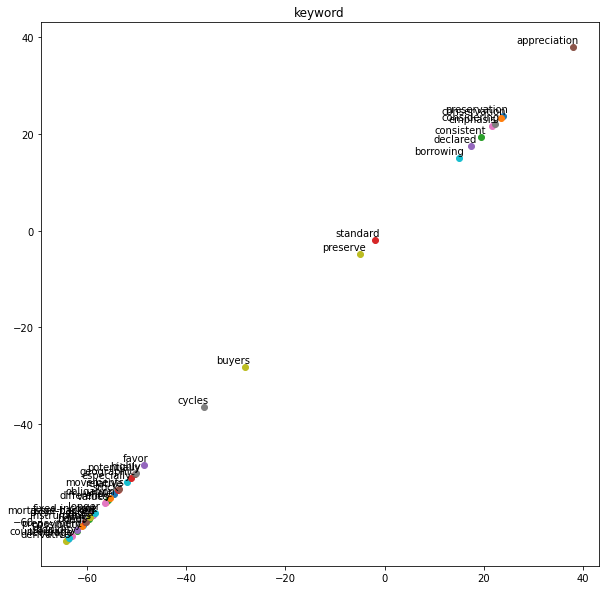

In [111]:
plt.figure(figsize=(10, 10)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
        xy=(x[i], y[i]),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')
plt.title('keyword')
plt.show()

### Create a Knowledge Base

In [26]:
# Creates the knwoledge base by taking the num_neighbors closes neighbors of each key_words in word2vec
def create_knowledge_base(num_neighbors, word2vec, key_words):
    knowledge_base = set()
    out = display(progress(0, len(key_words)-1), display_id=True)
    for ii, key_word in enumerate(key_words) :
        knowledge_base.add(key_word)
        neighbors = []
        try :
            neighbors = get_n_closer(key_word, num_neighbors, word2vec)
        except :
            print(key_word + ' not in word2vec')

        knowledge_base.update(neighbors)
        
        out.update(progress(ii, len(key_words)-1))
    return knowledge_base

In [27]:
keywords_list = [words_neighbors_1,words_neighbors_2,words_neighbors_3,words_neighbors_4]
knowledge_base = []
for keywords in keywords_list:
    knowledge_base.extend(create_knowledge_base(5, word2vec, keywords))

In [28]:
print(knowledge_base)

['providing', 'standard', 'emphasis', 'division', 'multi-cap', 'declared', 'freedom', 'cycle', 'membership', 'georgia', 'current', 'evaluated', 'municipality', 'morningstar', 'conservation', 'reimbursing', 'usaa', 'targeted', 'mandated', 'comprise', 'appreciation', 'borrowing', 'maximize', 'unmanaged', 'risk-managed', 'considering', 'classification', 'master', 'exemptions', 'index℠', 'repatriate', 'unlikely', 'preservation', 'ensure', 'spending', 'consistent', 'core', 'exempt-interest', 'bear', 'preserve', 'rated', 'mortgage-related', 'longer', 'bonds', 'maturity', 'values', 'instruments', 'fixed-income', 'asset-backed', 'exposure', 'tend', 'junk', 'durations', 'convertible', 'maturities', 'debt', 'sensitive', 'non-u.s.', 'fall', 'preferred', 'prices', 'estate', 'mortgage-backed', 'mid-capitalization', 'whose', 'equity', 'etfs', 'preferred', 'smaller', 'small-', 'stocks', 'exposure', 'many', 'mid-cap', 'primarily', 'convertible', 'common', 'often', 'typically', 'non-u.s.', 'larger', 'e

### Scoring Function

In [29]:
# We create here the dataframe tha contains the summaries along with their labels
df_extraction = pd.DataFrame({'fund_name' : fund_names, 'summary':summaries})
df_label = pd.read_csv(summary_lables_path)
df = df_label.merge(df_extraction, on='fund_name', how='left').dropna()
df.head()

,id,fund_name,Performance fee?,Ivestment Strategy,Leverage?,Portfolio composition,Concentration,summary
0,0000051931-18-000151,American Funds College 2018 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2018 Fund\n\nInvestment...
1,0000051931-18-000151,American Funds College 2021 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2021 Fund\n\nInvestment...
2,0000051931-18-000151,American Funds College 2024 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2024 Fund\n\nInvestment...
3,0000051931-18-000151,American Funds College 2027 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2027 Fund\n\nInvestment...
4,0000051931-18-000151,American Funds College 2030 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2030 Fund\n\nInvestment...


In [30]:
#check the prediction style
df['Ivestment Strategy'].value_counts()

Equity Long Only (Low Risk)          247
Fixed Income Long Only (Low Risk)    130
Balanced Fund (Low Risk)              84
Long Short Funds (High Risk)           4
Commodities Fund (Low Risk)            1
Name: Ivestment Strategy, dtype: int64

In [31]:
#drop Commodities Fund
df = df[df['Ivestment Strategy'] != 'Commodities Fund (Low Risk)']

In [32]:
def extract_sentence_match(summary, knowledge, num_sent):
    sentences = sent_tokenize(summary)
    sentence_scores = []
    for j, sentence in enumerate(sentences):
        set_tokens = set(tokenizer(sentence))

        # Find the number of common words between the knowledge base and the sentence
        inter_knwoledge = set_tokens.intersection(knowledge)

        sentence_scores.append(len(inter_knwoledge))

    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[len(sentences)-num_sent-1:]
    return ' '.join(top_sentences)

In [33]:
# It takes several minutes (5-10 minutes)
df['strategy_sentences_match'] = df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=5), axis=1)

###  Information extraction using deep classifiers

#### Format Data

In [34]:
low_risk = df[df['Ivestment Strategy'] != 'Long Short Funds (High Risk)']
low_risk['Ivestment Strategy code'] = low_risk['Ivestment Strategy'].astype('category').cat.codes
X_low_risk = low_risk['strategy_sentences_match'].values
X_low_risk = [' '.join(tokenizer(txt)) for txt in X_low_risk]
y_low_risk = low_risk['Ivestment Strategy code'].values

high_risk = df[df['Ivestment Strategy'] == 'Long Short Funds (High Risk)']
X_high_risk = high_risk['strategy_sentences_match'].values
X_high_risk = [' '.join(tokenizer(txt)) for txt in X_high_risk]
y_high_risk = [3,3,3,3]

/Users/estelle/opt/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [35]:
X_train_low_risk, X_test_low_risk, y_train_low_risk, y_test_low_risk = train_test_split(X_low_risk, y_low_risk, test_size = 0.1, random_state=30)

In [36]:
X_train_low_risk, X_valid_low_risk, y_train_low_risk, y_valid_low_risk = train_test_split(X_train_low_risk,y_train_low_risk, test_size=0.1)

In [37]:
X_train_high_risk, X_test_high_risk, y_train_high_risk, y_test_high_risk = train_test_split(X_high_risk, y_high_risk, test_size = 0.1, random_state=30)

In [38]:
X_train_high_risk, X_valid_high_risk, y_train_high_risk, y_valid_high_risk = train_test_split(X_train_high_risk, y_train_high_risk, test_size = 0.1, random_state=30)

In [39]:
X_train = X_train_high_risk + X_train_low_risk
y_train = y_train_high_risk + y_train_low_risk.tolist()

X_test = X_test_high_risk + X_test_low_risk
y_test = y_test_high_risk + y_test_low_risk.tolist()

X_val = X_valid_high_risk + X_valid_low_risk
y_val = y_valid_high_risk + y_valid_low_risk.tolist()

/Users/estelle/opt/anaconda3/envs/tf/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/estelle/opt/anaconda3/envs/tf/lib/python3.6/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

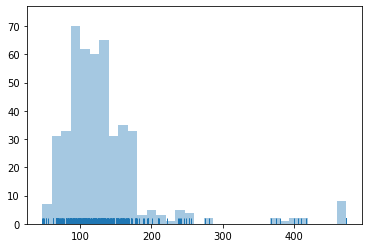

In [40]:
# In order to set the length of the document series (maxlen), we visualise the distribution of the number of words per documents.
X = df['strategy_sentences_match'].values
# X = df['deriv_sentences_distance'].values # uncomment to use the first sentence extraction method.
# Clean the texts
X = [' '.join(tokenizer(txt)) for txt in X]
X[0][:100]
sizes = []
out = display(progress(0, len(X)), display_id=True)
for ii, txt in enumerate(X):
    sizes.append(len(word_tokenize(txt)))
    out.update(progress(ii, len(X)))

sns.distplot(sizes, kde=False, rug=True)

In [41]:
num_words = 2500 # Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
maxlen = 180 # Number of word considered for each document. we cut or lengthen the texts to have texts of 150 words.
word_dimension = 50 # dimension of our word vectors.

In [42]:
# The Tokenizer provided by the Keras library allows to perform such transformation.
keras_tokenizer = Tokenizer(num_words=num_words)
keras_tokenizer.fit_on_texts(X_train)
# word_index is the dictionary that contains the index of each words in our 2500 long vocabulary.
word_index = keras_tokenizer.word_index
sequences_train = keras_tokenizer.texts_to_sequences(X_train)
sequences_test = keras_tokenizer.texts_to_sequences(X_val)

In [43]:
print('Text : '+X_train[0])
print('Index sequences : ' +str(sequences_train[0]))

Text : normal market conditions fund invests directly indirectly unaffiliated exchange traded funds etfs mutual funds together etfs underlying funds least net assets plus amount borrowings long short positions equity securities derivative prices highly volatile may fluctuate substantially short period time inverse etfs fall price stock prices rising small medium sized companies normally lower trading volume larger companies may tend make market price fall disproportionately larger companies response selling pressures may limited markets product lines financial resources lack management experience adviser decision buy sell fund holding made based adviser developed trend risk models evaluate current market conditions analysis guide adviser determination appropriate exposure level equity market least fund assets invested u.s. foreign equity securities market capitalization including underlying funds primarily invest otherwise exposed domestic foreign equity securities derivative instrumen

In [44]:
X_train = pad_sequences(sequences_train, maxlen=maxlen, dtype=float, padding='post', truncating='post')
X_val = pad_sequences(sequences_test, maxlen=maxlen, dtype=float, padding='post', truncating='post')

In [45]:
print ('length of the first sequence : '+str(len(sequences_train[0])) )
print ('length of the paded first sequence : '+str(len(X_train[0])) )

length of the first sequence : 141
length of the paded first sequence : 180


In [46]:
word2vec_g = load_word2vec(glove_word2vec)

In [47]:
embedding_matrix = np.zeros((len(word_index) + 1, word_dimension))
for word, i in word_index.items():
    embedding_vector = word2vec_g.get(word)
    #embedding_vector = word2vec.get(word)   # uncomment to use our own word2vec
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### First Model: CNN

In [48]:
def create_CNN_model():
    CNN = Sequential()
    # The Embedding layer takes the embedding matrix as an argument and transform the inputed the sequences of index to sequences of vectors.
    CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))


    CNN.add(Convolution1D(64, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Convolution1D(32, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Flatten())
    CNN.add(Dense(units = 128 , activation = 'relu'))
    CNN.add(Dropout(0.5))
    CNN.add(Dense(units = 1, activation = 'sigmoid'))

    CNN.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return CNN

In [49]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(k_neighbors=1)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [50]:
CNN_model = create_CNN_model()

In [51]:
CNN_history = CNN_model.fit(X_train, y_train, epochs=10, batch_size=40, validation_data=(X_val, y_val))

Train on 333 samples, validate on 84 samples
Epoch 1/10
333/333 [==============================] - 1s 4ms/step - loss: -0.5880 - acc: 0.5045 - val_loss: -0.1930 - val_acc: 0.5476
Epoch 2/10
333/333 [==============================] - 1s 2ms/step - loss: -2.1111 - acc: 0.5255 - val_loss: -0.1898 - val_acc: 0.5476
Epoch 3/10
333/333 [==============================] - 1s 2ms/step - loss: -2.2980 - acc: 0.5255 - val_loss: -0.1898 - val_acc: 0.5476
Epoch 4/10
333/333 [==============================] - 1s 2ms/step - loss: -2.2980 - acc: 0.5255 - val_loss: -0.1898 - val_acc: 0.5476
Epoch 5/10
333/333 [==============================] - 1s 2ms/step - loss: -2.2980 - acc: 0.5255 - val_loss: -0.1898 - val_acc: 0.5476
Epoch 6/10
333/333 [==============================] - 1s 2ms/step - loss: -2.2980 - acc: 0.5255 - val_loss: -0.1898 - val_acc: 0.5476
Epoch 7/10
333/333 [==============================] - 1s 2ms/step - loss: -2.2980 - acc: 0.5255 - val_loss: -0.1898 - val_acc: 0.5476
Epoch 8/10
333/33

In [53]:
pred_CNN = CNN_model.predict(X_val)

In [56]:
print(confusion_matrix(y_val,pred_CNN))

[[ 0 19  0  0]
 [ 0 46  0  0]
 [ 0 18  0  0]
 [ 0  1  0  0]]


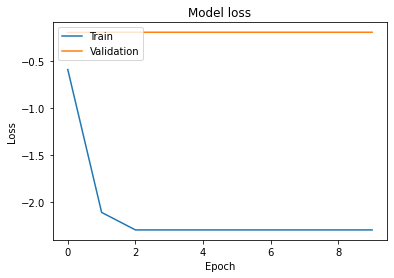

In [61]:
# Plot training & validation loss values
plt.plot(CNN_history.history['loss'])
plt.plot(CNN_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Second Model: Logistic Regression

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
warnings.warn('ignore')
lm = LogisticRegression(multi_class='auto', max_iter=100, solver = 'liblinear')
lm.fit(X_train, y_train)

/Users/estelle/opt/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: ignore
  after removing the cwd from sys.path.


LogisticRegression(solver='liblinear')

In [59]:
pred_lm = lm.predict(X_val)
print(classification_report(y_val,pred_lm))

              precision    recall  f1-score   support

           0       0.67      0.84      0.74        19
           1       0.76      0.63      0.69        46
           2       0.45      0.56      0.50        18
           3       0.00      0.00      0.00         1

    accuracy                           0.65        84
   macro avg       0.47      0.51      0.48        84
weighted avg       0.67      0.65      0.65        84



/Users/estelle/opt/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/estelle/opt/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/estelle/opt/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

### Third Model: Random Forest

In [60]:
from sklearn.ensemble import RandomForestClassifier
warnings.warn('ignore')
rf = RandomForestClassifier(class_weight='balanced',random_state=1)
params = {'n_estimators':[200,400,600,800],
          'max_features':['sqrt', 'log2', "auto", 10],
          'max_leaf_nodes':[15, 20, 25], 
          'min_samples_leaf': [6, 10, 17], 
          'max_depth':[9, 12, 15]}
gsv_rf = GridSearchCV(rf, params, cv=3, n_jobs=-1, scoring='accuracy')
gsv_rf.fit(X_train_res,y_train_res)

/Users/estelle/opt/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: ignore
  


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=1),
             n_jobs=-1,
             param_grid={'max_depth': [9, 12, 15],
                         'max_features': ['sqrt', 'log2', 'auto', 10],
                         'max_leaf_nodes': [15, 20, 25],
                         'min_samples_leaf': [6, 10, 17],
                         'n_estimators': [200, 400, 600, 800]},
             scoring='accuracy')

In [62]:
gsv_rf.best_params_

{'max_depth': 12,
 'max_features': 'sqrt',
 'max_leaf_nodes': 25,
 'min_samples_leaf': 6,
 'n_estimators': 400}

In [64]:
pred_rf = gsv_rf.best_estimator_.predict(X_val)

In [66]:
print(classification_report(y_val,pred_rf))

              precision    recall  f1-score   support

           0       0.82      0.74      0.78        19
           1       0.73      0.83      0.78        46
           2       0.60      0.50      0.55        18
           3       0.00      0.00      0.00         1

    accuracy                           0.73        84
   macro avg       0.54      0.52      0.52        84
weighted avg       0.72      0.73      0.72        84



/Users/estelle/opt/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/estelle/opt/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/estelle/opt/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [67]:
pred_rf = rf.fit(X_train_res,y_train_res).predict(X_val)
print(classification_report(y_val,pred_rf))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86        19
           1       0.75      0.93      0.83        46
           2       0.82      0.50      0.62        18
           3       0.00      0.00      0.00         1

    accuracy                           0.80        84
   macro avg       0.63      0.56      0.58        84
weighted avg       0.80      0.80      0.78        84



/Users/estelle/opt/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/estelle/opt/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/estelle/opt/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

### Fourth Model: Support Vector Machine

In [68]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X_train_res, y_train_res)
poly = svm.SVC(kernel='poly', degree=3, C=1).fit(X_train_res, y_train_res)

In [70]:
poly_pred = poly.predict(X_val)
rbf_pred = rbf.predict(X_val)

In [71]:
poly_accuracy = accuracy_score(y_val, poly_pred)
poly_f1 = f1_score(y_val, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial Kernel):  46.43
F1 (Polynomial Kernel):  47.37


In [72]:
rbf_accuracy = accuracy_score(y_val, rbf_pred)
rbf_f1 = f1_score(y_val, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (RBF Kernel):  8.33
F1 (RBF Kernel):  10.89


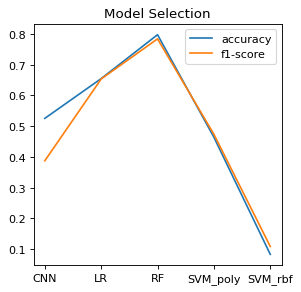

In [80]:
#accuracy compare
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score,confusion_matrix,roc_curve
plt.figure(figsize=(4, 4), dpi=80)
x = ["CNN","LR","RF","SVM_poly","SVM_rbf"]
accuracy = [CNN_history.history['acc'][9],accuracy_score(y_val, pred_lm),accuracy_score(y_val, pred_rf),
            poly_accuracy,rbf_accuracy]
f1 = [f1_score(y_val,pred_CNN,average='weighted'),f1_score(y_val,pred_lm,average='weighted'),
      f1_score(y_val,pred_rf,average='weighted'),poly_f1,rbf_f1]
p1 = plt.plot(x, accuracy)
p2 = plt.plot(x, f1)
ax = plt.gca()
ax.legend([p1[0], p2[0]],['accuracy','f1-score'])
ax.set_title('Model Selection')
plt.show()

### Prediction

Among the four model above, We can find random forest has the highest accuracy and f1 score which means it has the best performance, so we choose this model to predict the test data.

In [82]:
#remove the high risk, only fit three low risk fund
# The Tokenizer provided by the Keras library allows to perform such transformation.
keras_tokenizer = Tokenizer(num_words=num_words)
keras_tokenizer.fit_on_texts(X_train_low_risk)
# word_index is the dictionary that contains the index of each words in our 2500 long vocabulary.
word_index = keras_tokenizer.word_index
sequences_train_low_risk = keras_tokenizer.texts_to_sequences(X_train_low_risk)
sequences_test_low_risk = keras_tokenizer.texts_to_sequences(X_valid_low_risk)

X_train_low_risk = pad_sequences(sequences_train_low_risk, maxlen=maxlen, dtype=float, padding='post', truncating='post')
X_valid_low_risk = pad_sequences(sequences_test_low_risk, maxlen=maxlen, dtype=float, padding='post', truncating='post')

In [83]:
rf_low = RandomForestClassifier(class_weight='balanced',random_state=12)
rf_low.fit(X_train_low_risk,y_train_low_risk)

RandomForestClassifier(class_weight='balanced', random_state=12)

In [84]:
pred_rf_low = rf_low.predict(X_valid_low_risk)
print(classification_report(y_valid_low_risk,pred_rf_low))

              precision    recall  f1-score   support

           0       1.00      0.68      0.81        19
           1       0.71      1.00      0.83        46
           2       1.00      0.28      0.43        18

    accuracy                           0.77        83
   macro avg       0.90      0.65      0.69        83
weighted avg       0.84      0.77      0.74        83



In [89]:
params = {'n_estimators':[200,400,600,800],
          'max_features':['sqrt', 'log2', "auto", 10],
          'max_leaf_nodes':[15, 20, 25], 
          'min_samples_leaf': [6, 10, 17], 
          'max_depth':[9, 12, 15]}
gsv_rf_low = GridSearchCV(rf_low, params, cv=3, n_jobs=-1, scoring='accuracy')
gsv_rf_low.fit(X_train_low_risk,y_train_low_risk) 

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=12),
             n_jobs=-1,
             param_grid={'max_depth': [9, 12, 15],
                         'max_features': ['sqrt', 'log2', 'auto', 10],
                         'max_leaf_nodes': [15, 20, 25],
                         'min_samples_leaf': [6, 10, 17],
                         'n_estimators': [200, 400, 600, 800]},
             scoring='accuracy')

In [90]:
gsv_rf_low.best_params_

{'max_depth': 9,
 'max_features': 10,
 'max_leaf_nodes': 20,
 'min_samples_leaf': 6,
 'n_estimators': 400}

In [92]:
pred_rf_low_gsv = gsv_rf_low.best_estimator_.predict(X_valid_low_risk)
print(classification_report(y_valid_low_risk,pred_rf_low_gsv))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        19
           1       0.73      0.80      0.76        46
           2       0.62      0.44      0.52        18

    accuracy                           0.72        83
   macro avg       0.71      0.68      0.69        83
weighted avg       0.72      0.72      0.72        83



In [94]:
#choose rf to predict
#remove the high risk, only fit three low risk fund
# The Tokenizer provided by the Keras library allows to perform such transformation.
keras_tokenizer = Tokenizer(num_words=num_words)
keras_tokenizer.fit_on_texts(X_test)
# word_index is the dictionary that contains the index of each words in our 2500 long vocabulary.
word_index = keras_tokenizer.word_index
sequences = keras_tokenizer.texts_to_sequences(X_test)

X_test = pad_sequences(sequences, maxlen=maxlen, dtype=float, padding='post', truncating='post')

prediction = rf.predict(X_test)

In [99]:
accuracy_score(y_test, prediction)

0.6666666666666666

In [100]:
confusion_matrix(y_test,prediction)

array([[ 6,  2,  1,  0],
       [ 2, 19,  5,  0],
       [ 0,  5,  7,  0],
       [ 1,  0,  0,  0]])

In [102]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         9
           1       0.73      0.73      0.73        26
           2       0.54      0.58      0.56        12
           3       0.00      0.00      0.00         1

    accuracy                           0.67        48
   macro avg       0.48      0.50      0.49        48
weighted avg       0.66      0.67      0.66        48



/Users/estelle/opt/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/estelle/opt/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/estelle/opt/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [119]:
prediction

array([0, 1, 1, 2, 0, 1, 1, 1, 1, 2, 2, 1, 0, 2, 1, 2, 1, 0, 1, 2, 0, 1,
       0, 2, 0, 1, 1, 2, 1, 1, 0, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 2, 1, 0])